$\Large\color{blue}{\text{PyGMTSAR Sentinel-1 SLC Timeseries Analysis 2 Scenes 6 Subswaths 15m}}$

$\Large\color{blue}{\text{This notebook is optimized to work in Docker container (Ubuntu 22.04 Jammy) 16 GB RAM 1 GB swap 4 cores}}$

### PyGMTSAR is my free-time Open Source project.

That's a bit curious how the project was started a year ago. I develop geophysical inversion methods and processing software for many years using my fundamental physics and mathematics background. Satellite interferometry is the key point to validate my inversion models and I found the same problem as you too that the existing interferometry packages usage is a pain. There is no interactive processing with multiprocessing and even a progressbar and ability to view and change every step code and validate the results. Also, many used algorithms are too outdated and produce terrible results like to tension surfaces in GMT which is used widely in GMTSAR (hmm, how about to control a smothness of derivative? Tension surfaces were invented when all the Earths computers where less powerfull than your smarthone today. If you are interested I shared the examples in GMTSAR bug tracker). Anyway, I found GMT mathematics is really crazy and the developers replace one incorrect algorithm by another and back often as we see in the codes and the changelog). That was enough reason to check all the used algorithms and replace these by modern and correct ones. By this way, I use only GMTSAR C codes with my patches to fix some errors and allow interoperability with Python wrappers plus my own codes around them. GMTSAR codes are fine and without crazy GMT codes work better and the processing is much faster. Alright, I spent one month to make the initial PyGMTSAR realization and it works. Recently, I returned to the project to add some more sophisticated features like to scenes and subswathes stitching. I'm going to share some of my geological exprorations and seismic models as live examples on Google Colab as soon as it will be possible to do. How lineaments and ore zones are related to interferograms? How gas and oil deposits are related to surface movements on interferometry displacement maps? I have the answer and I work on the tools to model and visualize them.

You'd find my theoretical models and processing codes foir geophisical inversions in Github repository https://github.com/mobigroup/gis-snippets and tools for the 4D results vizualization in https://github.com/mobigroup/ParaView-plugins

Ah yes, a little bit about me. I have STEM master's degree in radio physics and in 2004 I was awarded first prize of the All-Russian Physics competition for significant results in Inverse modeling for non-linear optics and holography, also applicable for Inverse Modeling of Gravity, Magnetic, and Thermal fields. In addition to my fundamental science knowledge, I’m world class data scientist and software developer with 20 years experience in science and industrial development. I have worked on government contracts and universities projects and on projects for LG Corp, Google Inc, etc. You are able to find some of my software and results on LinkedIn and GitHub and Upwork. By the way, I left Russia many years ago and I work remotely for about 20 years.

### To order some research, development and support see my profile on freelance platform [Upwork](https://www.upwork.com/freelancers/~01e65e8e7221758623)

### @ Alexey Pechnikov, August, 2022

[Geological models on YouTube channel](https://www.youtube.com/channel/UCSEeXKAn9f_bDiTjT6l87Lg)

[Augmented Reality (AR) Geological Models](https://mobigroup.github.io/ParaView-Blender-AR/)

[GitHub repositories](https://github.com/mobigroup)

[English posts and articles on LinkedIn](https://www.linkedin.com/in/alexey-pechnikov/)

[Russian articles on Habr](https://habr.com/ru/users/N-Cube/posts/)

## Load Modules to Check Environment

In [1]:
import platform, sys, os

## Load and Setup Python Modules

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import json
import scipy.signal
# supress numpy warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# plotting modules
import hvplot.pandas  # noqa
import hvplot.xarray  # noqa
import holoviews as hv
pd.options.plotting.backend = 'hvplot'
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [4]:
# define Pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Load Custom Python Modules

In [5]:
# default chunksize (512) is enough suitable for a single subswath processing using resolution 15m
# select higher chunk size (1024) to process multiple subswaths and scenes using resolution 15m
from pygmtsar import datagrid
datagrid.chunksize = 1024

In [6]:
# import the top level class
from pygmtsar import SBAS
# show progress indicator for the long operations
from pygmtsar import tqdm_dask

## Define Processing Parameters

In [7]:
ORBIT     = 'D'
#SUBSWATH  = 123
# common configuration
#DATADIR      = 'data_asc' if ORBIT == 'A' else 'data_desc'
#BACKUP       = 'backup_asc' if ORBIT == 'A' else 'backup_desc'
#BACKUP       = None
WORKDIR      = 'raw_asc' if ORBIT == 'A' else 'raw_desc'
#DEMFILE      = None
#POLARIZATION = 'VV'
# SBAS parameters
#BASEDAYS     = 65
#BASEMETERS   = 150
#RESOLUTION   = 15

In [8]:
# minimal mean stack correlation to define AOI valid pixels
#TARGETCORRLIMIT = 0.5
# exclude low-coherence areas like to water surfaces
#CORRLIMIT = 0.15

In [9]:
# define helper function
#def detrend(pair):
#    return sbas.detrend(pair, wavelength=20000, fit_intercept=True, fit_dem=True, fit_coords=True, debug=False)

## Run Local Dask Cluster

For multicore processing of the all big rasters launch Dask cluster

In [10]:
import dask, dask.distributed
# increase timeouts to work using default chunk size (512) even on large areas
dask.config.set({'distributed.comm.timeouts.tcp': '60s'})
#print (dask.config.get("distributed.comm.timeouts.tcp"))
dask.config.set({'distributed.comm.timeouts.connect': '60s'})
#print (dask.config.get("distributed.comm.timeouts.connect"))

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:35689' processes=1 threads=4, memory=15.61 GiB>

## Restore SBAS

In [11]:
sbas = SBAS.restore(WORKDIR)

NOTE: load state from file raw_desc/SBAS.pickle


In [12]:
sbas.to_dataframe()

datetime orbit mission polarization  subswath  \
date                                                                  
2022-01-09 2022-01-09 02:52:55     D     S1A           VV       123   
2022-01-21 2022-01-21 02:52:54     D     S1A           VV       123   
2022-02-02 2022-02-02 02:52:54     D     S1A           VV       123   
2022-02-14 2022-02-14 02:52:54     D     S1A           VV       123   
2022-02-26 2022-02-26 02:52:54     D     S1A           VV       123   
2022-03-10 2022-03-10 02:52:54     D     S1A           VV       123   
2022-03-22 2022-03-22 02:52:54     D     S1A           VV       123   
2022-04-03 2022-04-03 02:52:54     D     S1A           VV       123   
2022-04-15 2022-04-15 02:52:54     D     S1A           VV       123   
2022-04-27 2022-04-27 02:52:55     D     S1A           VV       123   

                                                                                                                                                                                                                                                    datapath  \
date                                                                                                                                                                                                                                                           
2022-01-09  [raw_desc/s1a-iw1-slc-vv-20220109t025257-20220109t025347-041378-04eb6a-004.tiff, raw_desc/s1a-iw2-slc-vv-20220109t025255-20220109t025348-041378-04eb6a-005.tiff, raw_desc/s1a-iw3-slc-vv-20220109t025256-20220109t025346-041378-04eb6a-006.tiff]   
2022-01-21  [raw_desc/s1a-iw1-slc-vv-20220121t025256-20220121t025346-041553-04f124-004.tiff, raw_desc/s1a-iw2-slc-vv-20220121t025254-20220121t025347-041553-04f124-005.tiff, raw_desc/s1a-iw3-slc-vv-20220121t025255-20220121t025345-041553-04f124-006.tiff]   
2022-02-02  [raw_desc/s1a-iw1-slc-vv-20220202t025256-20220202t025346-041728-04f723-004.tiff, raw_desc/s1a-iw2-slc-vv-20220202t025254-20220202t025346-041728-04f723-005.tiff, raw_desc/s1a-iw3-slc-vv-20220202t025255-20220202t025345-041728-04f723-006.tiff]   
2022-02-14  [raw_desc/s1a-iw1-slc-vv-20220214t025256-20220214t025346-041903-04fd3e-004.tiff, raw_desc/s1a-iw2-slc-vv-20220214t025254-20220214t025347-041903-04fd3e-005.tiff, raw_desc/s1a-iw3-slc-vv-20220214t025255-20220214t025345-041903-04fd3e-006.tiff]   
2022-02-26  [raw_desc/s1a-iw1-slc-vv-20220226t025256-20220226t025345-042078-050346-004.tiff, raw_desc/s1a-iw2-slc-vv-20220226t025254-20220226t025346-042078-050346-005.tiff, raw_desc/s1a-iw3-slc-vv-20220226t025255-20220226t025345-042078-050346-006.tiff]   
2022-03-10  [raw_desc/s1a-iw1-slc-vv-20220310t025255-20220310t025345-042253-050934-004.tiff, raw_desc/s1a-iw2-slc-vv-20220310t025254-20220310t025346-042253-050934-005.tiff, raw_desc/s1a-iw3-slc-vv-20220310t025255-20220310t025345-042253-050934-006.tiff]   
2022-03-22  [raw_desc/s1a-iw1-slc-vv-20220322t025256-20220322t025346-042428-050f2a-004.tiff, raw_desc/s1a-iw2-slc-vv-20220322t025254-20220322t025347-042428-050f2a-005.tiff, raw_desc/s1a-iw3-slc-vv-20220322t025255-20220322t025345-042428-050f2a-006.tiff]   
2022-04-03  [raw_desc/s1a-iw1-slc-vv-20220403t025256-20220403t025346-042603-051519-004.tiff, raw_desc/s1a-iw2-slc-vv-20220403t025254-20220403t025347-042603-051519-005.tiff, raw_desc/s1a-iw3-slc-vv-20220403t025255-20220403t025345-042603-051519-006.tiff]   
2022-04-15  [raw_desc/s1a-iw1-slc-vv-20220415t025256-20220415t025346-042778-051afd-004.tiff, raw_desc/s1a-iw2-slc-vv-20220415t025254-20220415t025347-042778-051afd-005.tiff, raw_desc/s1a-iw3-slc-vv-20220415t025255-20220415t025345-042778-051afd-006.tiff]   
2022-04-27  [raw_desc/s1a-iw1-slc-vv-20220427t025257-20220427t025347-042953-0520ba-004.tiff, raw_desc/s1a-iw2-slc-vv-20220427t025255-20220427t025348-042953-0520ba-005.tiff, raw_desc/s1a-iw3-slc-vv-20220427t025256-20220427t025346-042953-0520ba-006.tiff]   

                                                                                                

## Find SBAS Pairs and Dates

Scan work directory to find all the processed pairs

In [13]:
pairs = sbas.find_pairs('corr')
pairs

array([['20220109', '20220121'],
       ['20220109', '20220202'],
       ['20220109', '20220214'],
       ['20220109', '20220226'],
       ['20220109', '20220310'],
       ['20220121', '20220202'],
       ['20220121', '20220214'],
       ['20220121', '20220226'],
       ['20220121', '20220310'],
       ['20220121', '20220322'],
       ['20220202', '20220214'],
       ['20220202', '20220226'],
       ['20220202', '20220310'],
       ['20220202', '20220322'],
       ['20220202', '20220403'],
       ['20220214', '20220226'],
       ['20220214', '20220310'],
       ['20220214', '20220322'],
       ['20220214', '20220403'],
       ['20220214', '20220415'],
       ['20220226', '20220310'],
       ['20220226', '20220322'],
       ['20220226', '20220403'],
       ['20220226', '20220415'],
       ['20220226', '20220427'],
       ['20220310', '20220322'],
       ['20220310', '20220415'],
       ['20220310', '20220427'],
       ['20220322', '20220403'],
       ['20220322', '20220415'],
       ['2

In [14]:
dates = sbas.find_dates()
dates

array(['20220109', '20220121', '20220202', '20220214', '20220226',
       '20220310', '20220322', '20220403', '20220415', '20220427'],
      dtype='<U8')

## Build decimator for plots

Large grid plots require a lot of RAM so decimate plots to build smaller images visually almost the same as the original ones.

In [18]:
# decimate radar coordinate grids to plot
decimator = sbas.pixel_decimator(resolution_meters=600, debug=True)

DEBUG: average per subswaths ground pixel size in meters: y=14.0, x=14.6
DEBUG: decimator = lambda da: da.coarsen({'y': 43, 'x': 41}, boundary='trim').mean()


In [26]:
# use the same decimation in geographic coordinates
decimator_ll = lambda da: decimator(da.rename({'lat': 'y', 'lon': 'x'})).rename({'y': 'lat', 'x': 'lon'})

## Check and Export Area in Geographic Coordinates

Check if AOI is well covered by computed interferograms area. Low-coherence areas would be cropped on the next step (unwrapping).

To work effectivly on the large coherence grids stack aggregate all the grids (using max() function below) and geocode the single aggregated grid only.

In case of "CancelledError exception" just re-execute the cell. It means the data loading requires long time and looks unresponsive and the execution is failed for this reason.

In [15]:
# use the original resolution for the export фтв вусшьфеув ещ здще
corr_stack_max_ll = sbas.intf_ra2ll(sbas.open_grids(pairs, 'corr').max(['pair']))
corr_stack_max_ll

Loading:   0%|          | 0/34 [00:00<?, ?it/s]

<xarray.DataArray 'z' (lat: 25609, lon: 25860)>
dask.array<getitem, shape=(25609, 25860), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 36.53 36.53 36.53 36.53 ... 40.09 40.09 40.09 40.09
  * lon      (lon) float64 45.98 45.98 45.98 45.98 ... 49.57 49.57 49.57 49.57

In [16]:
filename = f'{WORKDIR}.corrstackmax.nc'
# drop the existing file first
!rm -fr {filename}
# read all the correlation grids as 3D stack and calculate maximum value for every pixel
delayed = corr_stack_max_ll.to_netcdf(filename, engine=sbas.engine, compute=False)
tqdm_dask(dask.persist(delayed), desc='Saving Max Stack Coherency as NetCDF')

Saving Max Stack Coherency as NetCDF:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


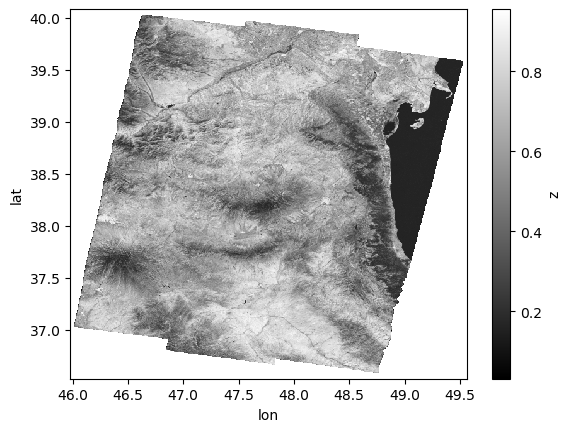

In [28]:
decimator_ll(xr.open_dataarray(filename)).plot.imshow(cmap='gray')

In [29]:
filename = f'{WORKDIR}.unwrapsample.nc'
# drop the existing file first
!rm -fr {filename}
# load one grid (pairs[:1]) in geographic coordinates
unwrap = sbas.open_grids(pairs[:1], 'unwrap')[0]
unwrap_ll = sbas.intf_ra2ll(unwrap)
delayed = unwrap_ll.to_netcdf(filename, engine=sbas.engine, compute=False)
tqdm_dask(dask.persist(delayed), desc='Saving Sample Unwrapped Grid as NetCDF')

Loading:   0%|          | 0/1 [00:00<?, ?it/s]

Saving Sample Unwrapped Grid as NetCDF:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

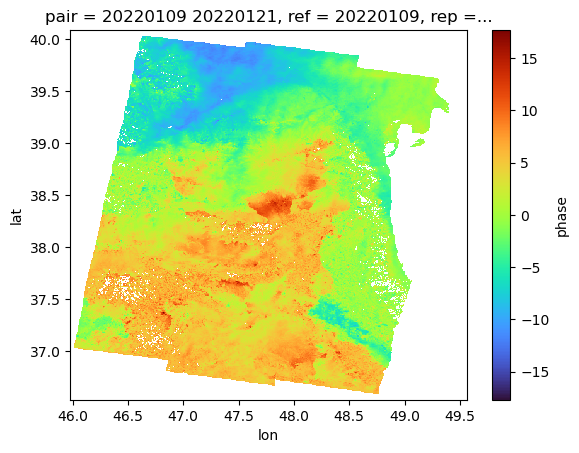

In [30]:
decimator_ll(xr.open_dataarray(filename)).plot.imshow(cmap='turbo')

## Save the Total Displacement in Geographic Coordinates

In [31]:
sbas_disps = sbas.open_grids(dates, 'disp', func=[sbas.los_displacement_mm])
sbas_disps

Loading:   0%|          | 0/10 [00:00<?, ?it/s]

<xarray.DataArray 'displacement' (date: 10, y: 25612, x: 16918)>
dask.array<concatenate, shape=(10, 25612, 16918), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * date     (date) <U8 '20220109' '20220121' ... '20220415' '20220427'
  * x        (x) float64 186.0 190.0 194.0 ... 6.785e+04 6.785e+04 6.785e+04
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 2.561e+04 2.561e+04 2.561e+04

In [33]:
sbas_disps_total_ll = sbas.intf_ra2ll(sbas_disps.cumsum('date')[-1])
sbas_disps_total_ll

<xarray.DataArray 'displacement' (lat: 25609, lon: 25860)>
dask.array<getitem, shape=(25609, 25860), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 36.53 36.53 36.53 36.53 ... 40.09 40.09 40.09 40.09
  * lon      (lon) float64 45.98 45.98 45.98 45.98 ... 49.57 49.57 49.57 49.57
    date     <U8 '20220427'

In [34]:
filename = f'{WORKDIR}.displacement.nc'
# drop the existing file first
!rm -fr {filename}
# read all the correlation grids as 3D stack and calculate maximum value for every pixel
delayed = sbas_disps_total_ll.to_netcdf(filename, engine=sbas.engine, compute=False)
tqdm_dask(dask.persist(delayed), desc='Saving Total Displacement as NetCDF')

Saving Total Displacement as NetCDF:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

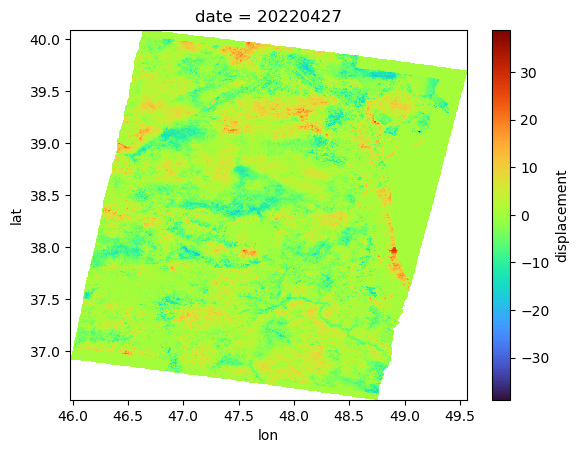

In [35]:
decimator_ll(xr.open_dataarray(filename)).plot.imshow(cmap='turbo')

## Done

All the interferograms geocoded and exported and the project can be restored later to continue the analysis. That's safer to create a new notebook for the post-processing because plotting a large timeseries requires a lot of RAM and the notebook can be out of RAM at any time.